# 실습01. 이미지 분류기에 전이학습 적용하기 - (1) 기초

## [ 목차 ]

1. 데이터 가져오기<br>
2. 전처리<br>
&emsp;2.1. 데이터 포맷 조정]<br>
&emsp;2.2. 데이터 늘리기<br>
3. (사전학습된) Base Model 가져오기<br>
4. 상위 층에 분류기 추가<br>
5. 학습
6. 예측 & 예측 결과

- 목표
    - 사전학습된 이미지 분류 모델 VGG16를 이용해 10개 클래스를 가진 CIFAR-10 이미지 데이터를 분류
- 참고자료
    - 파이썬을 활용한 딥러닝 전이학습(2019) CH6
    - ChatGPT
- 이미지 분류 시 전이학습에 사용할만한 사전학습 모델
    - AlexNet
    - VGG-16
    - Inception a.k.a. GoogleNet
    - ResNet
    - MobileNet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 가져오기: CIFAR-10

- 각 클래스에는 6,000개의 32x32 크기의 컬러 이미지가 포함. 전체 데이터셋은 60,000개의 이미지로 구성. 
-  CIFAR-10 데이터셋의 클래스 목록
    1. Airplane (비행기)
    2. Automobile (자동차)
    3. Bird (새)
    4. Cat (고양이)
    5. Deer (사슴)
    6. Dog (개)
    7. Frog (개구리)
    8. Horse (말)
    9. Ship (배)
    10. Truck (트럭) 

- 데이터 가져오기 & train, validation, test 셋 분할

In [2]:
from tensorflow.keras.datasets import cifar10

# CIFAR-10 데이터셋 로드
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# 데이터셋의 크기 출력
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Train set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [3]:
from sklearn.model_selection import train_test_split

# X_train과 y_train을 85%:15%의 비율로 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# 나눠진 데이터의 크기 출력
print("훈련 세트 크기:", X_train.shape, y_train.shape)
print("검증 세트 크기:", X_val.shape, y_val.shape)

훈련 세트 크기: (42500, 32, 32, 3) (42500, 1)
검증 세트 크기: (7500, 32, 32, 3) (7500, 1)


- 데이터 확인

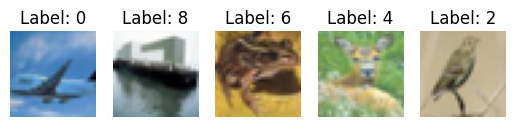

In [4]:
import matplotlib.pyplot as plt

# Display the first few images from the train set
num_images = 5

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[i][0]}")
    plt.axis('off')

plt.show()


# 2. 전처리

## 2.1. 데이터 포맷 조정

- label 원핫인코딩

In [5]:
from tensorflow.keras.utils import to_categorical

# 원 핫 인코딩
num_classes = 10
Y_train = to_categorical(y_train, num_classes=num_classes)
Y_val = to_categorical(y_val, num_classes=num_classes)
Y_test = to_categorical(y_test, num_classes=num_classes)

- 이미지 사이즈 조정: VGG16 모델의 input size에 맞춰 CIFAR 데이터셋 이미지 사이즈 조정

In [6]:
# 이미지 사이즈 조정: (48, 48)

from PIL import Image
import numpy as np

# 이미지 크기 조절 함수
def resize_images(images, new_size):
    resized_images = []
    for img in images:
        pil_img = Image.fromarray(img)
        resized_img = pil_img.resize(new_size)
        resized_images.append(np.array(resized_img))
    return np.array(resized_images)

# 대상 이미지 크기
target_size = (48, 48)

# X_train, X_val, X_test 이미지 크기 조절
X_train = resize_images(X_train, target_size)
X_val = resize_images(X_val, target_size)
X_test = resize_images(X_test, target_size)


## 2.2. 데이터 늘리기

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
batch_size = 100

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = False)
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train, 
                                     Y_train, 
                                     batch_size = batch_size)

val_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = False)
val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val, 
                                     Y_val, 
                                     batch_size = batch_size)

In [10]:
# train_generator의 배치 형태 확인
batch_images, batch_labels = train_generator.next()
print("Batch images shape:", batch_images.shape)
print("Batch labels shape:", batch_labels.shape)

Batch images shape: (100, 48, 48, 3)
Batch labels shape: (100, 10)


# 3. (사전학습된) Base Model 가져오기

In [11]:
from keras.applications import vgg16
from keras.models import Model
import keras

- VGG16 주요 파라미터
    1. `weights`: 모델 초기 가중치를 설정하는 파라미터로, 'imagenet'으로 설정하면 ImageNet 데이터셋에서 미리 훈련된 가중치를 사용함.
        - ImageNet 데이터셋에는 1,000개 이상의 카테고리가 있으며, 각 카테고리에는 수천 개의 이미지가 포함. 예를 들어, 고양이, 강아지, 자동차, 비행기 등 다양한 객체 및 동물이 포함.
    2. `include_top`: 최상위 완전 연결 레이어를 포함할지 여부를 결정하는 파라미터로, True로 설정하면 포함함.
    3. `input_shape`: 입력 이미지의 형태를 지정하는 파라미터로, 일반적으로 (224, 224, 3) 크기의 이미지를 입력으로 사용함.

In [12]:
base_model = vgg16.VGG16(include_top=False, 
                        weights="imagenet",
                        input_shape=(48,48,3))

In [13]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [14]:
# 마지막 레이어의 이름
last_layer_name = base_model.layers[-1].name
last_layer_name

'block5_pool'

In [15]:
# VGG16에서 마지막 레이어 추출
last = base_model.get_layer(last_layer_name).output
last

<KerasTensor: shape=(None, 1, 1, 512) dtype=float32 (created by layer 'block5_pool')>

# 4. 상위 층에 분류기 추가

In [16]:
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Model

In [17]:
base_model.input

<KerasTensor: shape=(None, 48, 48, 3) dtype=float32 (created by layer 'input_1')>

In [18]:
x = GlobalAveragePooling2D()(last)
x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.6)(x)
pred = Dense(num_classes, activation="softmax")(x)
model = Model(base_model.input, pred)

# layer.trainable = False: 전이 학습을 할 때, 미리 훈련된 모델의 가중치를 고정하고 
# 그 위에 추가적인 레이어를 추가하여 새로운 작업에 적용
for layer in base_model.layers:
    layer.trainable = False


- 사전학습 모델 + 새 분류기 추가 모델 확인

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [20]:
for i in range(1,7)[::-1]:  
    print(model.layers[-i].name, model.layers[-i].output_shape)

global_average_pooling2d (None, 512)
batch_normalization (None, 512)
dense (None, 64)
dense_1 (None, 64)
dropout (None, 64)
dense_2 (None, 10)


# 5. 학습

- COLAB에서 학습 후, 학습된 모델을 가져옴

In [21]:
train_steps_per_epoch = X_train.shape[0] // batch_size
val_steps_per_epoch = X_val.shape[0] // batch_size
epoch = 30

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# # 주석 풀어서 학습 수행
# history = model.fit_generator(train_generator,
#                               steps_per_epoch = train_steps_per_epoch,
#                               validation_data = val_generator,
#                               validation_steps = val_steps_per_epoch,
#                               epochs = epoch,
#                               verbose = -1)

In [22]:
# # 모델 저장
# model.save("./trained_model/practice01_mod01.h5")

# # history 저장 (pickle을 사용)
# import pickle
# with open("./trained_model/practice01_history01.pkl", "wb") as file:
#     pickle.dump(history.history, file)

In [23]:
from tensorflow.keras.models import load_model

# 모델 불러오기
model = load_model("./trained_model/practice01_model01.h5")

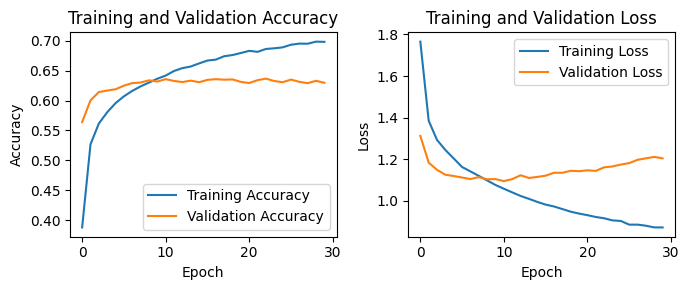

In [24]:
import pickle

# history 불러오기
with open("./trained_model/practice01_history01.pkl", "rb") as file:
    history = pickle.load(file)

# 훈련 정확도와 검증 정확도 그리기
plt.figure(figsize=(7,3))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# 훈련 손실과 검증 손실 그리기
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 그림 보여주기
plt.tight_layout()
plt.show()


# 6. 예측 & 예측 결과

In [25]:
y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(Y_test, axis=1)

313/313 [==============================] - 39s 125ms/step


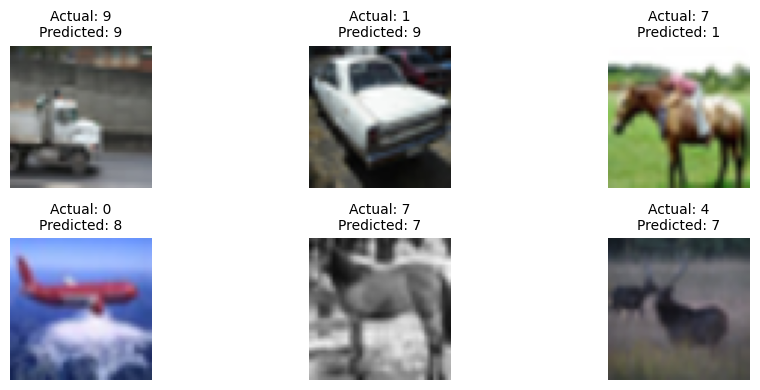

In [35]:
from sklearn.metrics import confusion_matrix
import random

# 랜덤 샘플 6개 선택
random_indices = random.sample(range(len(X_test)), 6)

# 선택한 랜덤 샘플에 대해 그림 그리기
plt.figure(figsize=(10, 4))
for i, idx in enumerate(random_indices, 1):
    plt.subplot(2, 3, i)
    plt.imshow(X_test[idx])
    plt.title(f"Actual: {y_true[idx]}\nPredicted: {y_pred_classes[idx]}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


# E.O.D.